# RQ2 Untested Patch Ranking

In [1]:
import os
import json
import pandas as pd
patch_directory = "../patches/patches_entropy_TBar"
patches_list = []
for subdir, _, files in os.walk(patch_directory):
    for file in files:
        bug = subdir.split("/")[-1]
        project = subdir.split("/")[-2]
        patch_id = int(file.split("_")[0].replace('.txt', ''))
        file_path = os.path.join(subdir, file)
        correct = True
        project_bug = f"{project}_{bug}"
        if "incorrect" in file_path:
            correct = False
        with open(file_path, "r") as f:
            patches_dict = json.load(f)
        patched_entropy = patches_dict["patched_entropy"]
        original_entropy = patches_dict["original_entropy"]
        average_patch_entropy = sum(patched_entropy.values()) / len(patched_entropy)
        average_original_entropy = sum(original_entropy.values()) / len(
            original_entropy
        )
        patches_dict["project_bug"] = project_bug
        patches_dict["tbar_rank"] = patch_id
        patches_dict["avg_patch_entropy"] = average_patch_entropy
        patches_dict["avg_original_entropy"] = average_original_entropy
        patches_dict["entropy_delta"] = average_original_entropy - average_patch_entropy
        patches_list.append(patches_dict)
df = pd.DataFrame(patches_list)
df["correct"] = df["correct"].astype(bool)
df["entropy_rank"] = df.groupby(["project", "bug_id"])["entropy_delta"].rank(
    ascending=False
).astype(int)

/home/aidan/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Total TBar vanilla repair time: 54.0 minutes and 15 seconds
Total entropy TBar repair time: 52.0 minutes and 32.14 seconds
Total test-cache entropy TBar repair time: 42.0 minutes and 12 seconds


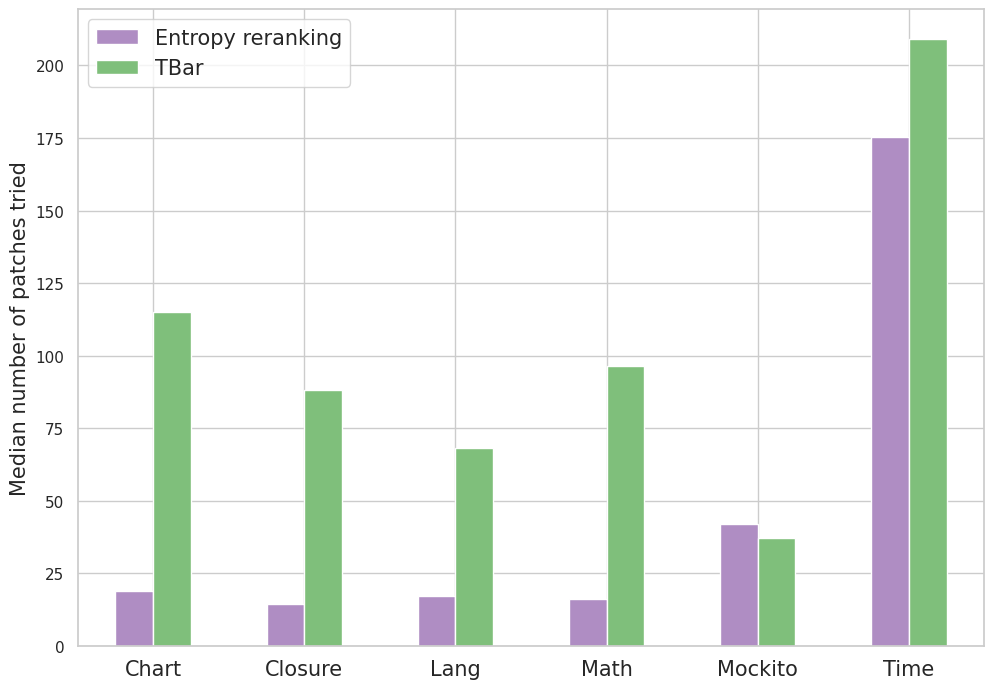

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# read csv
df_entropy = pd.read_csv('../patches/time_entropy_testcache.csv')
df_tbar = pd.read_csv('../patches/time_tbar_testcache.csv')
df_tbar_vanilla = pd.read_csv('../patches/time_tbar_vanilla.csv')


# give column names
df_entropy.columns = ['bug_id', 'repair_time_entropy', 'tried_patch_entropy']
df_tbar.columns = ['bug_id', 'repair_time_testcache', 'tried_patch_testcache']
df_tbar_vanilla.columns = ['bug_id', 'repair_time_vanilla', 'tried_patch_vanilla']

# merge all df by bug_id and keep column name
df_merged = pd.merge(df_entropy, df_tbar, on='bug_id')
df_merged = pd.merge(df_merged, df_tbar_vanilla, on='bug_id')

# convert to string
df_merged['bug_id'] = df_merged['bug_id'].astype(str)

df_merged['Defects4J Project'] = df_merged.bug_id.apply(lambda x: x.split('_')[0])

# remove bug_id column
df_merged = df_merged.drop('bug_id', axis=1)

df_grouped = df_merged.groupby('Defects4J Project').median()

# use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
# create a bar plot

ax = df_grouped.plot(y=["tried_patch_entropy", "tried_patch_vanilla"], kind="bar", color=["#af8dc3", "#7fbf7b"], rot=0)
# make all labels larger

ax.set_xticklabels(df_grouped.index, rotation=0, fontsize="15")
ax.set_ylabel('Median number of patches tried', fontsize="15")
ax.set_xlabel('', fontsize="15")


ax.legend(["Entropy reranking", "TBar"], fontsize="15")

plt.savefig("plots/untested_num_patches.pdf", bbox_inches='tight')
total_entropy_repair_time = df_entropy['repair_time_entropy'].sum()
total_tbar_repair_time = df_tbar['repair_time_testcache'].sum()
total_tbar_vanilla_repair_time = df_tbar_vanilla['repair_time_vanilla'].sum()
total_entropy_repair_time = round(total_entropy_repair_time, 2)
total_tbar_repair_time = round(total_tbar_repair_time, 2)
total_tbar_vanilla_repair_time = round(total_tbar_vanilla_repair_time, 2)

# convert time to minutes and seconds
total_entropy_repair_time = f"{total_entropy_repair_time//60} minutes and {round(total_entropy_repair_time%60, 2)} seconds"
total_tbar_repair_time = f"{total_tbar_repair_time//60} minutes and {round(total_tbar_repair_time%60)} seconds"
total_tbar_vanilla_repair_time = f"{total_tbar_vanilla_repair_time//60} minutes and {round(total_tbar_vanilla_repair_time%60)} seconds"
print(f"Total TBar vanilla repair time: {total_tbar_vanilla_repair_time}")
print(f"Total entropy TBar repair time: {total_entropy_repair_time}")
print(f"Total test-cache entropy TBar repair time: {total_tbar_repair_time}")

In [3]:
sorteddf = df[['project_bug', 'entropy_rank', 'tbar_rank']]
sorteddf = sorteddf.rename(columns={'tbar_rank': 'patch_id'})
sorteddf = sorteddf.groupby(["project_bug"]).apply(lambda x: x.sort_values(["entropy_rank"])).reset_index(drop=True)
dict_patches = sorteddf.groupby('project_bug').apply(lambda x: x[['entropy_rank', 'patch_id']].to_dict(orient='records'))

patches_to_json = {}
for project_bug, patch in dict_patches.items():
    patches_to_json[project_bug] = []
    for i, p in enumerate(patch):
        patch_file = "../TBar/stored_patches/" + project_bug + "/" + str(p['patch_id']) + ".json"
        if os.path.exists(patch_file):
            with open(patch_file, "r") as f:
                stored_patch_dict = json.load(f)
            p['patch_code1'] = stored_patch_dict['patchCode1']
            p['patch_code2'] = stored_patch_dict['patchCode2']
            p['exactBuggyCodeStartPos'] = stored_patch_dict['exactBuggyCodeStartPos']
            p['exactBuggyCodeEndPos'] = stored_patch_dict['exactBuggyCodeEndPos']
            patches_to_json[project_bug].append(p)

# convert new_dict_patches to pandas series
patches_to_json = pd.Series(patches_to_json)
patches_to_json.to_json('../TBar/entropy_patch_rank.json')

/tmp/ipykernel_1370725/4045855990.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorteddf = sorteddf.groupby(["project_bug"]).apply(lambda x: x.sort_values(["entropy_rank"])).reset_index(drop=True)
/tmp/ipykernel_1370725/4045855990.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dict_patches = sorteddf.groupby('project_bug').apply(lambda x: x[['entropy_rank', 'patch_id']].to_dict(orient='records'))

In [4]:

# convert entropy rank to integer
patchdf = df[['project', 'project_bug', 'correct', 'entropy_rank', 'tbar_rank']]
correct_df = patchdf[(patchdf['correct'] == True)]

print('Total correct patches ' , len(correct_df))
print(correct_df.groupby(['project']).size().reset_index(name='counts'))

correct_and_entropy_lessthan_tbar = patchdf[(patchdf['correct'] == True) & (patchdf['entropy_rank'] <= patchdf['tbar_rank'])]
print('Correct patches with entropy ranked higher than Tbar: ' , len(correct_and_entropy_lessthan_tbar))

correct_and_entropy_morethan_tbar = patchdf[(patchdf['correct'] == True) & (patchdf['entropy_rank'] > patchdf['tbar_rank']) & (patchdf['tbar_rank'] > 1)]
print('Correct patches with entropy ranked lower than Tbar: ' , len(correct_and_entropy_morethan_tbar))

correct_and_entropy_lessthan_tbar = correct_and_entropy_lessthan_tbar.groupby(['project']).size().reset_index(name='counts')
correct_and_entropy_morethan_tbar = correct_and_entropy_morethan_tbar.groupby(['project']).size().reset_index(name='counts')


correct_df['entropy_tbar_rank'] = correct_df['tbar_rank'] - correct_df['entropy_rank']
print(correct_df['entropy_tbar_rank'].describe())
print(patchdf.head())

Total correct patches  72
   project  counts
0    Chart      11
1  Closure      19
2     Lang      14
3     Math      21
4  Mockito       3
5     Time       4
Correct patches with entropy ranked higher than Tbar:  60
Correct patches with entropy ranked lower than Tbar:  9
count     72.000000
mean      23.597222
std       55.557269
min      -25.000000
25%        0.000000
50%        5.000000
75%       16.000000
max      374.000000
Name: entropy_tbar_rank, dtype: float64
  project project_bug  correct  entropy_rank  tbar_rank
0   Chart    Chart_16    False             1         59
1   Chart    Chart_16    False             7         22
2   Chart    Chart_16    False            11         23
3   Chart    Chart_16    False            21         52
4   Chart    Chart_16    False            20         58


/tmp/ipykernel_1370725/390761319.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_df['entropy_tbar_rank'] = correct_df['tbar_rank'] - correct_df['entropy_rank']


/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seabo

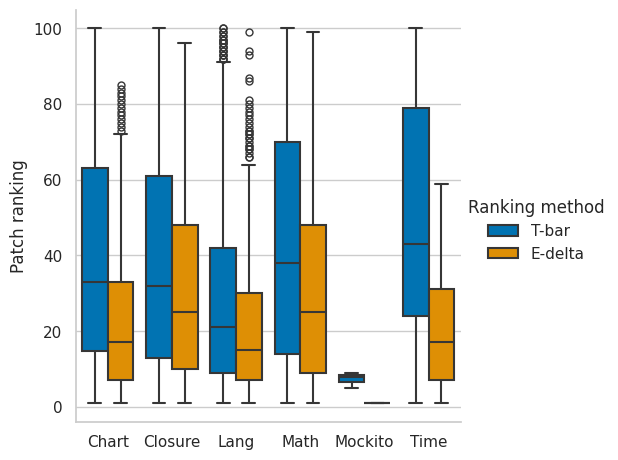

In [5]:
sns.set_theme(style="whitegrid")
df_melt = patchdf[['project', 'correct', 'tbar_rank', 'entropy_rank']]
df_melt = df_melt[df_melt['tbar_rank'] <= 100]
# df_melt = df_melt[df_melt['correct'] == True]
df_melt.columns = ["Project", "Test-passing patch", "TBar", "Entropy-delta"]
df_melt = pd.melt(df_melt, id_vars=["Project", "Test-passing patch"], value_vars=["TBar", "Entropy-delta"], 
                  var_name="Source", value_name="Patch ranking")
df_melt["Ranking method"] = df_melt["Source"].apply(lambda x: "E-delta" if x == "Entropy-delta" else "T-bar")

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="whitegrid")
sns.catplot(
    data=df_melt,
    kind="box",
    x="Project",
    y="Patch ranking",
    hue="Ranking method",
    sharey=True,
    height=5,
    saturation=5,
    linewidth=1.5,
    order=['Chart','Closure','Lang','Math','Mockito','Time'],
    # color
    palette="colorblind"
)
# set x label
plt.xlabel('', fontsize="15")
plt.savefig("plots/untested_ranking_both.pdf", bbox_inches='tight')

# RQ3 Tested Patch Ranking

In [6]:
import sys
import os
import json
import pandas as pd
patch_directory = "../patches/patches_entropy_shibboleth"
patches_list = []
for subdir, _, files in os.walk(patch_directory):
    for file in files:
        bug = subdir.split("/")[-1]
        project = subdir.split("/")[-2]
        file_path = os.path.join(subdir, file)
        correct = True
        if "incorrect" in file_path:
            correct = False
        with open(file_path, "r") as f:
            patches_dict = json.load(f)
        patched_entropy = patches_dict["patched_entropy"]
        original_entropy = patches_dict["original_entropy"]
        average_patch_entropy = sum(patched_entropy.values()) / len(patched_entropy)
        average_original_entropy = sum(original_entropy.values()) / len(
            original_entropy
        )
        patches_dict["avg_patch_entropy"] = average_patch_entropy
        patches_dict["avg_original_entropy"] = average_original_entropy
        patches_dict["entropy_delta"] = average_original_entropy - average_patch_entropy
        patches_list.append(patches_dict)
df = pd.DataFrame(patches_list)
df["correct"] = df["correct"].astype(bool)
print(df)

     project  bug_id                                          file_path  \
0      Chart      13  source/org/jfree/chart/block/BorderArrangement...   
1      Chart      13  source/org/jfree/chart/block/BorderArrangement...   
2      Chart      13  source/org/jfree/chart/block/BorderArrangement...   
3      Chart      13  source/org/jfree/chart/block/BorderArrangement...   
4      Chart      13  source/org/jfree/chart/block/BorderArrangement...   
...      ...     ...                                                ...   
1285    Math      63  src/main/java/org/apache/commons/math/util/Mat...   
1286    Math      63  src/main/java/org/apache/commons/math/util/Mat...   
1287    Math      63  src/main/java/org/apache/commons/math/util/Mat...   
1288    Math      63  src/main/java/org/apache/commons/math/util/Mat...   
1289    Math      63  src/main/java/org/apache/commons/math/util/Mat...   

                                        patched_entropy  \
0     {'443': 1.2529296875, '444': 0.845

In [7]:
## Top 2 and top 1 values
def top_n(df, n, project):
    if not project == "Total":
        df = df[df["project"] == project]
    top_n = len(df[df["correct"] & (df["patch_rank"] <= n)])
    print(f"{project}: top {n} ranking: {top_n}")


df["patch_rank"] = df.groupby(["project", "bug_id"])["entropy_delta"].rank(
    ascending=False
)


top_n(df, 1, "Chart")
top_n(df, 2, "Chart")

top_n(df, 1, "Closure")
top_n(df, 2, "Closure")

top_n(df, 1, "Lang")
top_n(df, 2, "Lang")

top_n(df, 1, "Math")
top_n(df, 2, "Math")

top_n(df, 1, "Mockito")
top_n(df, 2, "Mockito")

top_n(df, 1, "Time")
top_n(df, 2, "Time")

top_n(df, 1, "Total")
top_n(df, 2, "Total")

Chart: top 1 ranking: 10
Chart: top 2 ranking: 14
Closure: top 1 ranking: 48
Closure: top 2 ranking: 58
Lang: top 1 ranking: 20
Lang: top 2 ranking: 27
Math: top 1 ranking: 39
Math: top 2 ranking: 55
Mockito: top 1 ranking: 1
Mockito: top 2 ranking: 1
Time: top 1 ranking: 9
Time: top 2 ranking: 10
Total: top 1 ranking: 127
Total: top 2 ranking: 165


/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/aidan/miniconda3/envs/fuzzbench/lib/python3.10/site-packages/seabo

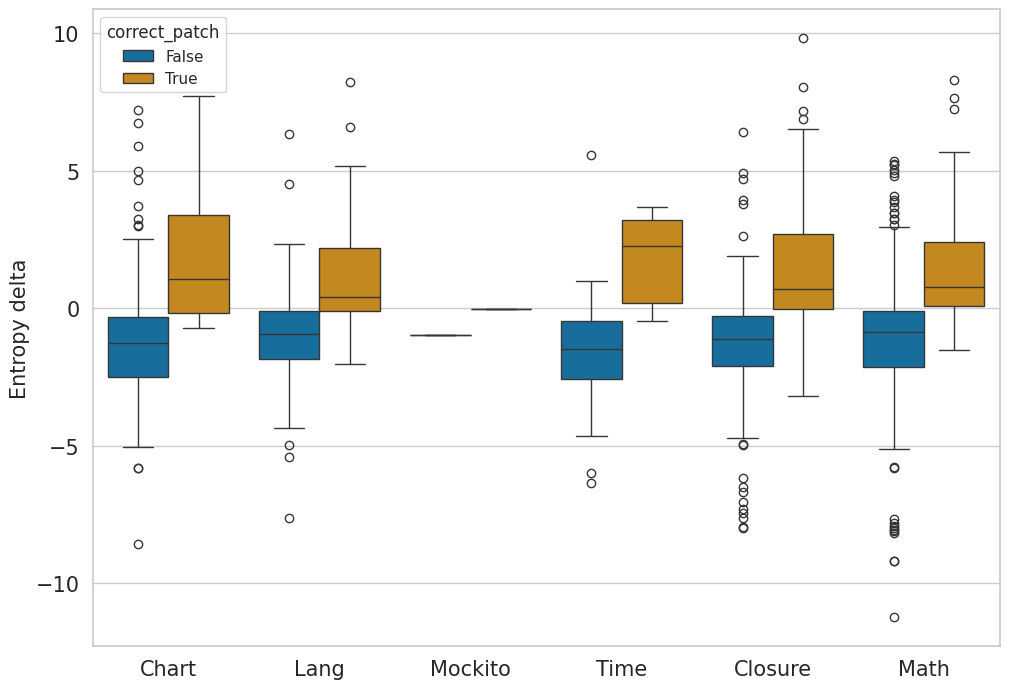

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")
df_melt = df[["project", "correct", "entropy_delta"]]
df_melt.columns = ["project", "correct_patch", "entropy_delta"]


# sns.catplot(
#     data=df_melt,
#     kind="box",
#     col="correct_patch",
#     x="project",
#     y="entropy_delta",
#     hue="project",
#     sharey=True,
#     height=5,
#     saturation=5,
#     linewidth=1.5,
#     dodge=False,
# )

# change above catplot to side by side boxplot

sns.boxplot(data=df_melt, x="project", y="entropy_delta", hue="correct_patch", palette="colorblind")
plt.xlabel('', fontsize="15")
plt.ylabel('Entropy delta', fontsize="15")
# change font size
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.savefig("plots/tested_ranking_edelta.pdf")

In [9]:
def classification(df, prior_tool, cutoff):
    df["patch_rank"] = df.groupby(["project", "bug_id"])["entropy_delta"].rank(
        ascending=False
    )
    df_mean_delta = (
        df.groupby(["project", "bug_id", "correct"])["entropy_delta"]
        .mean()
        .reset_index(name="avg_entropy_delta")
    )
    df_binary_delta = (
        df_mean_delta.groupby(["project", "bug_id", "correct"])["avg_entropy_delta"]
        .apply(lambda x: (x > cutoff).sum())
        .reset_index(name="positive_delta")
    )
    if prior_tool == "shibboleth":
        df_binary_delta = df_binary_delta.sample(n=139, random_state=0)

    true_positive_df = df_binary_delta[
        (df_binary_delta["correct"]) & df_binary_delta["positive_delta"] == 1
    ]
    false_positive_df = df_binary_delta[
        ~(df_binary_delta["correct"]) & (df_binary_delta["positive_delta"] == 1)
    ]
    true_negative_df = df_binary_delta[
        ~(df_binary_delta["correct"]) & (df_binary_delta["positive_delta"] == 0)
    ]
    false_negative_df = df_binary_delta[
        (df_binary_delta["correct"]) & (df_binary_delta["positive_delta"] == 0)
    ]

    true_positive = len(true_positive_df)
    false_positive = len(false_positive_df)
    true_negative = len(true_negative_df)
    false_negative = len(false_negative_df)

    print(f"True positive count: {true_positive}")
    print(f"True negative count: {true_negative}")

    print(f"False positive count: {false_positive}")
    print(f"False negative count: {false_negative}")

    accuracy = round(
        (true_positive + true_negative)
        / (true_positive + true_negative + false_positive + false_negative),
        3,
    )
    precision = round(true_positive / (true_positive + false_positive), 3)
    pos_recall = round(true_positive / (true_positive + false_negative), 3)
    neg_recall = round(true_negative / (true_negative + false_positive), 3)
    f1 = round(
        true_positive / (true_positive + 0.5 * (false_positive + false_negative)), 3
    )


    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"+recall: {pos_recall}")
    print(f"-recall: {neg_recall}")
    print(f"f1: {f1}")

In [10]:
classification(df, "shibboleth", -0.105)

True positive count: 53
True negative count: 62
False positive count: 11
False negative count: 13
accuracy: 0.827
precision: 0.828
+recall: 0.803
-recall: 0.849
f1: 0.815


In [11]:
patch_directory = "../patches/patches_entropy_panther"
patches_list = []
for subdir, _, files in os.walk(patch_directory):
    for file in files:
        bug = subdir.split("/")[-1]
        project = subdir.split("/")[-2]
        file_path = os.path.join(subdir, file)
        correct = True
        if "incorrect" in file_path:
            correct = False
        with open(file_path, "r") as f:
            patches_dict = json.load(f)
        patched_entropy = patches_dict["patched_entropy"]
        original_entropy = patches_dict["original_entropy"]
        average_patch_entropy = sum(patched_entropy.values()) / len(patched_entropy)
        average_original_entropy = sum(original_entropy.values()) / len(
            original_entropy
        )
        patches_dict["avg_patch_entropy"] = average_patch_entropy
        patches_dict["avg_original_entropy"] = average_original_entropy
        patches_dict["entropy_delta"] = average_original_entropy - average_patch_entropy
        patches_list.append(patches_dict)
df_panther = pd.DataFrame(patches_list)
df_panther["correct"] = df_panther["correct"].astype(bool)

In [ ]:
classification(df_panther, "panther", -0.55)